In [1]:
import os
import numpy as np
import math  
import matplotlib
import matplotlib.pyplot as plt
# from sklearn import linear_model
# from sklearn.linear_model import ElasticNet
# from sklearn.datasets import make_regression
# from sklearn.metrics import r2_score
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import Ridge
# from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
#                                               ExpSineSquared, DotProduct,
#                                               ConstantKernel)
import time
from sklearn.metrics import mean_squared_error
import pickle  
import datetime 
import json
import torch
import torch.nn as nn
from autograd import grad
import datetime

In [2]:
epsilon = 1
sigma = 1
rcut = 2.5
blx = 1.1832159566199232e+02
bly = 1.1832159566199232e+02
atoms = 9800

In [3]:
filename = 'data/testFxS1Sim60T1_2R_0_7atomDataCombined.npy'
# data = np.load('c70TrainatomDataCombined.npy')
data = np.load(filename)
print('Data shape ', data.shape)

# filename = 'data/dataAtomInd.npy'
# dataSys = np.load(filename)
# print(dataSys)

Data shape  (340323, 41)


In [15]:

# # shuffle data
N = data.shape[0]

# ids = np.arange(N)
# np.random.seed(0)
# np.random.shuffle(ids)
# data = unshuffled_data[ids]

class ObjectView(object):
    def __init__(self, d): 
        self.__dict__ = d
# data object
lamps_data = ObjectView({})

lamps_data.atom_id = data[:,0]
lamps_data.x = data[:,5]
lamps_data.y = data[:,6]
lamps_data.z = data[:,7]
lamps_data.fx = data[:,23]
lamps_data.fy = data[:,24]
lamps_data.vx = data[:,20]
lamps_data.vy = data[:,21]
lamps_data.timestep = data[:,26]
lamps_data.force1Px = data[:,27]
lamps_data.force1Py = data[:,28]
lamps_data.force1Pz = data[:,29]
lamps_data.forcexleftPx = data[:,30]
lamps_data.forcexleftPy = data[:,31]
lamps_data.forcexleftPz = data[:,32]
lamps_data.temp = data[:,33]
lamps_data.KE = data[:,34]
lamps_data.PE = data[:,35]
lamps_data.TE = data[:,36]
lamps_data.Pressure = data[:,37]
lamps_data.VxA = data[:,38]
lamps_data.VyA = data[:,39]
lamps_data.VzA = data[:,40]
lamps_data.length = N

lamps_data.x.shape
lamps_data.length

340323

In [17]:
# Symmetry of data

lamps_data.forcexleftPy = (lamps_data.y>(bly/2)) * -1 * lamps_data.forcexleftPy + (lamps_data.y<=(bly/2)) * lamps_data.forcexleftPy
lamps_data.y = (lamps_data.y>(bly/2)) * (bly - lamps_data.y) + (lamps_data.y<=(bly/2)) * lamps_data.y
lamps_data.forcexleftPx = (lamps_data.x>(blx/2)) * -1 * lamps_data.forcexleftPx + (lamps_data.x<=(blx/2)) * lamps_data.forcexleftPx
lamps_data.x = (lamps_data.x>(blx/2)) * (blx - lamps_data.x) + (lamps_data.x<=(blx/2)) * lamps_data.x

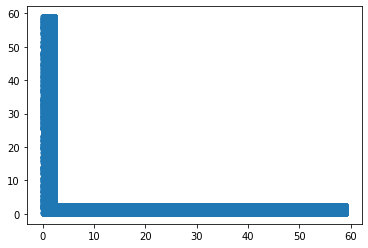

In [18]:
plt.plot(lamps_data.x,lamps_data.y,'.')

In [7]:
# Assemble Xtrain and Ytrain
# Xtrain is the input

def get_Xdata_atomic(lamps_data, test_fraction=0.1):
    """ The atomic data is simply position and velocity"""
    # we're only doing 2D data
    X = np.vstack([lamps_data.x, lamps_data.y, lamps_data.vx, lamps_data.vy, lamps_data.force1Px, lamps_data.force1Py])
    Ntest = int(lamps_data.length * 0.1)
    Xtest = X[:, :Ntest].T
    Xtrain = X[:, Ntest:].T
    return Xtrain, Xtest

def get_Ydata(lamps_data, test_fraction=0.1):
    """ The output data is the X and Y forces"""
    # we're only doing 2D data
    Y = np.vstack([lamps_data.forcexleftPx, lamps_data.forcexleftPy])
    Ntest = int(lamps_data.length * 0.1)
    Ytest = Y[:, :Ntest].T
    Ytrain = Y[:, Ntest:].T
    return Ytrain, Ytest


In [8]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(306291, 6)
(306291, 2)
(34032, 6)
(34032, 2)


In [34]:
# save model
def to_info(score, regressor_options, model_type='sklearn.neural_network.MLPRegressor'):
    info = { 'data_filename': filename,
             'model_type': model_type,
             'score': score,
             'regressor_options': regressor_options,
            }
    return info 


def get_timestamp():
    return datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

def save_model(model_file, model, info):
    timestamp = get_timestamp()
    mlpfile = 'trained_multilayer_perceptron_' + timestamp + '.pkl'
    model_folder = 'trained_models/'
    pickle.dump((model, info), open(model_folder + model_file, 'wb'))
    print('Model saved to %s' % model_file)
    
def load_model(model_file):
    print('Loading model from %s' % model_file)
    model_folder = 'trained_models/'
    model, info = pickle.load(open(model_folder + model_file, 'rb'))
    print(json.dumps(info, indent=1))
    return model, info

figs = []

def subplots(n=1):
    f, ax = plt.subplots(n)
    figs.append(f)
    return f, ax 

def plot_MLP_regressor(regr, Xtest, Ytest, figname):
    f, ax = subplots()
    Ytest_pred = regr.predict(Xtest)
    ax.scatter(Ytest[:, 0], Ytest[:, 1], label='Ground Truth', alpha=0.7)
    ax.scatter(Ytest_pred[:, 0], Ytest_pred[:, 1], label='Predicted', alpha=0.7)
    ax.legend()
    ax.set_xlabel('Forxe x direction [N]')
    ax.set_ylabel('Forxe ydirection [N]')
    ax.set_title('Predictions with Testing Data')
    figfile = ('mlp_%s.png' % figname)
    f.savefig(figfile)
    print('Saved plot to %s.' % figfile)
    plt.show()  

In [ ]:
old_model = load_model('trained_torch_NN_v0_09-05-2020_20-38-52.pkl', '', '')

In [31]:
# pytorch network

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.L1 = nn.Linear(6, 30)
        self.L2 = nn.Linear(30, 30)
        self.L3 = nn.Linear(30, 20)
        self.L4 = nn.Linear(20, 15)
        self.output = nn.Linear(15, 2)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        out = self.L1(x)
        out = self.ReLU(out)
        out = self.L2(out)
        out = self.ReLU(out)
        out = self.L3(out)
        out = self.ReLU(out)
        out = self.L4(out)
        out = self.ReLU(out)
        out = self.output(out)
        
        return out

In [32]:
test_fraction = 0.9
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

Xtrain_torch = torch.from_numpy(Xtrain)
Xtrain_torch = Xtrain_torch.type(torch.FloatTensor)
Ytrain_torch = torch.from_numpy(Ytrain)
Ytrain_torch = Ytrain_torch.type(torch.FloatTensor)
Xtest_torch = torch.from_numpy(Xtest)
Xtest_torch = Xtest_torch.type(torch.FloatTensor)
Ytest_torch = torch.from_numpy(Ytest)
Ytest_torch = Ytest_torch.type(torch.FloatTensor)
print(Xtrain_torch.shape)

torch.Size([306291, 6])


In [33]:
Net = NN()
train_error = np.array([])
test_error = np.array([])
optimizer = torch.optim.Adam(Net.parameters(), lr=0.0005)
for epoch in range(1000):
    optimizer.zero_grad()
    pred = Net.forward(Xtrain_torch)
    loss = ((pred - Ytrain_torch) * (pred - Ytrain_torch) ).mean()
    loss.backward()
    optimizer.step()
    val = loss.detach().numpy()
    train_error = np.append(train_error,val)
    pred_test = Net.forward(Xtest_torch)
    loss_test = ((pred_test - Ytest_torch) * (pred_test - Ytest_torch) ).mean()
    val = loss_test.detach().numpy()
    test_error = np.append(test_error,val)

In [36]:
torch_options = {'lr': 0.0005, 'optim': 'Adam', 'loss': 'mean', 'score':test_error[-1]}
tor_info = to_info(score=test_error[-1], regressor_options=torch_options, model_type='torch')
timestamp = get_timestamp()
torch_file = 'trained_torch_NN_v0_' + timestamp + '.pkl'
save_model(model_file=torch_file, model=Net, info=tor_info)

Model saved to trained_torch_NN_v0_09-05-2020_20-38-52.pkl


In [37]:
def plot_training_curve(net, train_error, test_error, figname):
    f, ax = subplots()
    ax.plot(train_error, label='Train Error')
    ax.plot(test_error, label='Test Error')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')
    ax.legend()
    ax.set_title('Training curves')
    figfile = ('torch_training_curve_%s.png' % figname)
    f.savefig(figfile)
    print('Saved plot to %s.' % figfile)
    
    
def histogram_error(net, Xtest, Ytest, figname):
    f, ax = subplots()
    Ypred = net(Xtest)
    Yerr = Ytest - Ypred
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')
    ax.legend()
    ax.set_title('Training curves')
    figfile = ('torch_hist_error%s.png' % figname)
    f.savefig(figfile)
    print('Saved plot to %s.' % figfile)


sh torch.Size([34032, 2])
torch.Size([34032, 2])
Error 25, 50, 75th percentiles (tensor(0.0102, grad_fn=<SelectBackward>), tensor(0.1162, grad_fn=<SelectBackward>), tensor(10.2245, grad_fn=<SelectBackward>))


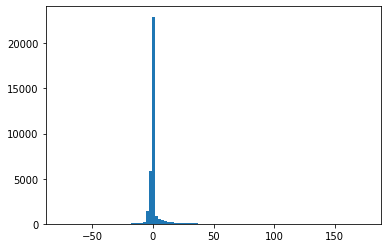

In [43]:
# plot_torch(Net, train_error, test_error, 'NN_4layer')
ypr = Net(Xtest_torch)
print('sh', ypr.shape)
yerr = (ypr - Ytest_torch).pow(2)
print(yerr.shape)
yerr = torch.mean((ypr - Ytest_torch).pow(2),axis=1)
yerr, _ = torch.sort(yerr)
n = len(yerr)
n_25th_p = yerr[int(n*0.25)]
n_50th_p = yerr[int(n*0.50)]
n_75th_p = yerr[int(n*0.75)]
print("Error 25, 50, 75th percentiles", (n_25th_p, n_50th_p, n_75th_p))

plt.hist(Ytest_torch[:, 0], bins=100)
plt.show()


(34032, 6)
(2000, 1)


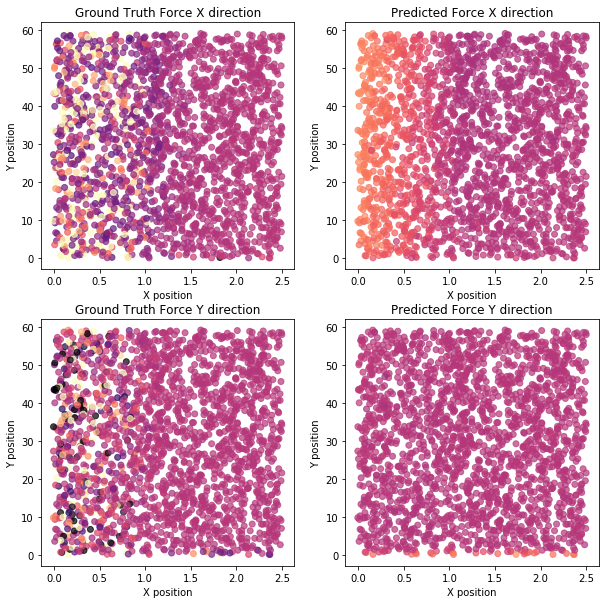

In [55]:
f, ax = plt.subplots(2,2, figsize=(10,10))

ind_plot = np.argwhere(Xtest[:,0]<2.5)
ind_plot = ind_plot[0:2000]
print(Xtest.shape)
print(Xtest[ind_plot, 0].shape)
ypr = ypr.detach()

vmax = 10
vmin = -10
ax[0,0].scatter(Xtest[ind_plot, 0], Xtest[ind_plot, 1], c=Ytest[ind_plot, 0], cmap='magma', alpha=0.7, vmin=vmin, vmax=vmax)
ax[0,1].scatter(Xtest[ind_plot, 0], Xtest[ind_plot, 1], c=ypr[ind_plot, 0], cmap='magma', alpha=0.7, vmin=vmin, vmax=vmax)
ax[1,0].scatter(Xtest[ind_plot, 0], Xtest[ind_plot, 1], c=Ytest[ind_plot, 1], cmap='magma', alpha=0.7, vmin=vmin, vmax=vmax)
ax[1,1].scatter(Xtest[ind_plot, 0], Xtest[ind_plot, 1], c=ypr[ind_plot, 1], cmap='magma', alpha=0.7, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Ground Truth Force X direction')
ax[1,0].set_title('Ground Truth Force Y direction')
ax[0,1].set_title('Predicted Force X direction')
ax[1,1].set_title('Predicted Force Y direction')
for axx in ax:
    for axxx in axx:
        axxx.set_xlabel('X position')
        axxx.set_ylabel('Y position')

plt.show()

In [ ]:
regressor_options = { 'hidden_layer_sizes':(40,40,40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)


In [ ]:
# score model using r^2 metric:
score = regr.score(Xtest, Ytest)
print(score)

info = to_info(score, regressor_options)
figname = '4by4'
plot_MLP_regressor(regr, Xtest, Ytest, figname)

In [ ]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

regressor_options = { 'hidden_layer_sizes':(40,40,40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print('Score %2.4f" score)
    
info = to_info(score, regressor_options)



In [ ]:
regressor_options = { 'hidden_layer_sizes':(40,40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
regressor_options = { 'hidden_layer_sizes':(40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)
score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
regressor_options = { 'hidden_layer_sizes':(40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
regressor_options = { 'hidden_layer_sizes':(40,40,40,40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
regressor_options = { 'hidden_layer_sizes':(40,40,40,40,40,40),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

regressor_options = { 'hidden_layer_sizes':(30,30,30,30),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

regressor_options = { 'hidden_layer_sizes':(20,20,20,20),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

regressor_options = { 'hidden_layer_sizes':(50,50,50,50),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)

In [ ]:
test_fraction = 0.1
Xtrain, Xtest = get_Xdata_atomic(lamps_data, test_fraction=test_fraction)
Ytrain, Ytest = get_Ydata(lamps_data, test_fraction=test_fraction)

regressor_options = { 'hidden_layer_sizes':(60,60,60,60),
                      'random_state':0,  # Random seed 
                    }

regr = MLPRegressor(**regressor_options)

regr.fit(Xtrain, Ytrain)

score = regr.score(Xtest, Ytest)
print(score)